# In this kernel we’ll try to identify correctly if the image we’re seeing is a dog=1 or a cat=0 .
# In order to do so I’ll use dog & cat image dataset as input to a data augmentation generator + CNN . 
# After optimzation process - optimal layers are 5 + 2 FC layers 
# I also run semi grid search on dropout , filter size .etc.. 


# Imports

In [1]:
import numpy as np
import pandas as pd 
import zipfile
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from subprocess import check_output
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import os
print(check_output(["ls", "../input/"]).decode("utf8"))

Using TensorFlow backend.


sampleSubmission.csv
test1.zip
train.zip



# Extract all train images

In [2]:
with zipfile.ZipFile('../input/train.zip', 'r') as z:    
    z.extractall(".") 
#print(check_output(["ls", "train"]).decode("utf8"))
   

# Get  filenames paths + define category (1 - dog , 0 - cat) and fill both of those varibles inside dataframe

In [3]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head(10) ##spot check 


,filename,category
0,dog.10277.jpg,1
1,dog.6983.jpg,1
2,dog.3723.jpg,1
3,dog.8086.jpg,1
4,dog.1707.jpg,1
5,dog.9232.jpg,1
6,cat.4601.jpg,0
7,dog.12304.jpg,1
8,dog.10582.jpg,1
9,cat.5873.jpg,0


# Define constant for CNN & data augmentation generator

In [4]:
FAST_RUN       = False
IMAGE_WIDTH    =128
IMAGE_HEIGHT   =128
IMAGE_SIZE     =(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS =3
DROP_OUT_VALUE =0.25
FILTER_SIZE    =(3, 3)
POOL_SIZE      =(2, 2)

# Load & plot random image from DF

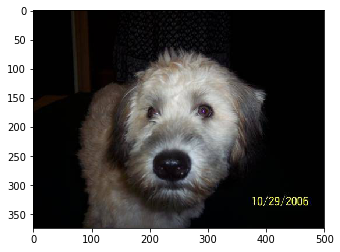

In [5]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Count  dog & cat images

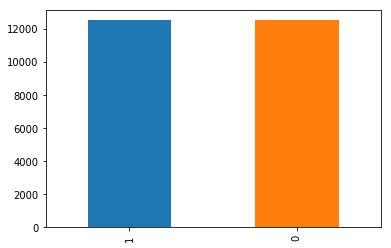

In [6]:
df['category'].value_counts().plot.bar()

# Inside training data we have 24000 dog & cat images

# We have 6 tiers where inside each tier we have : 
# Conv layer ->  batch normalization -> max pooling -> dropout 
# Last layer will include FC layer : flatten ->dense ->droput ->dense 
# Input layer: We'll take the images and resample image from Height X Weight X 3 ->  256 X256 X 3
# Output Layer: classify dog=1 or cat =0 

In [7]:


model = Sequential()

model.add(Conv2D(32, FILTER_SIZE, activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Dropout(DROP_OUT_VALUE))

model.add(Conv2D(64, FILTER_SIZE, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Dropout(DROP_OUT_VALUE))

model.add(Conv2D(128, FILTER_SIZE, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Dropout(DROP_OUT_VALUE))


model.add(Conv2D(192, FILTER_SIZE, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Dropout(0.35))

model.add(Conv2D(256, FILTER_SIZE, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=POOL_SIZE))
model.add(Dropout(0.45))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROP_OUT_VALUE))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2

#  Early Stop - prevent over fitting we will stop the learning after 10 epochs or val_loss not decreased 

In [8]:
earlystop = EarlyStopping(patience=15)

# Learning Rate Reduction-reduce learning rate when then accuracy not increase for 2 steps

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.0001)

In [10]:
callbacks = [earlystop, learning_rate_reduction]

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [11]:
df.head()

,filename,category
0,dog.10277.jpg,1
1,dog.6983.jpg,1
2,dog.3723.jpg,1
3,dog.8086.jpg,1
4,dog.1707.jpg,1


In [12]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,category
0,dog.10277.jpg,dog
1,dog.6983.jpg,dog
2,dog.3723.jpg,dog
3,dog.8086.jpg,dog
4,dog.1707.jpg,dog


In [13]:
train_df, validate_df = train_test_split(df, test_size=0.25, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

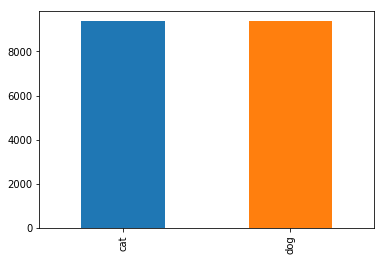

In [14]:
train_df['category'].value_counts().plot.bar()

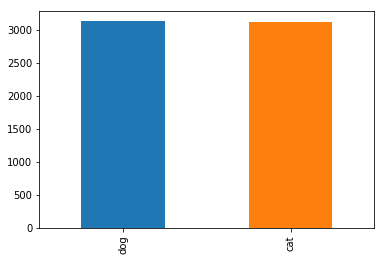

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
total_train

18750

# Traning Generator

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 18750 images belonging to 2 classes.


### Validation Generator

In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 6250 images belonging to 2 classes.


# See how our generator work

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


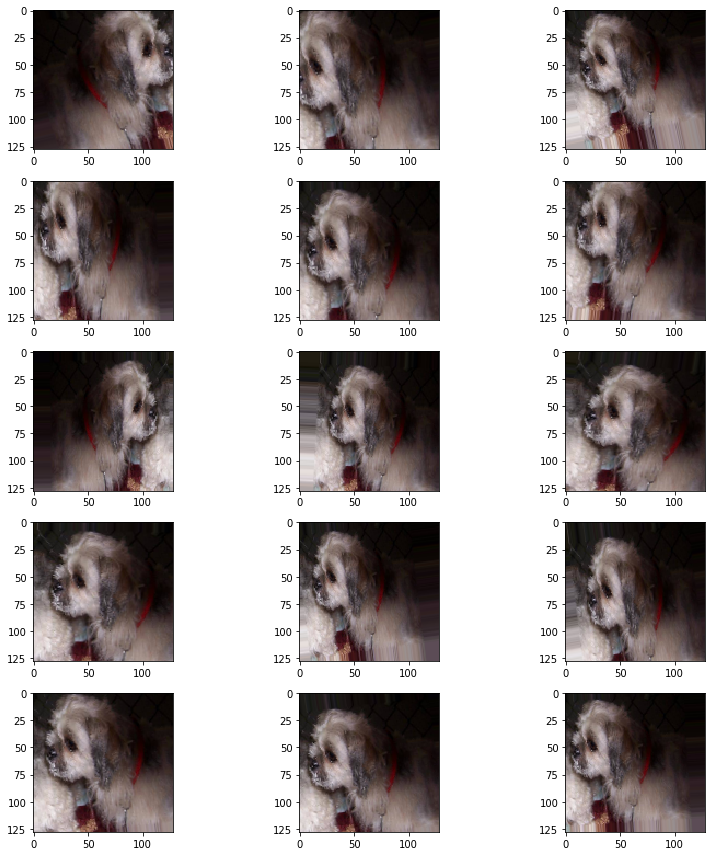

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [21]:
epochs=3 if FAST_RUN else 16
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/16
1250/1250 [==============================] - 1250s 1s/step - loss: 0.7645 - acc: 0.5846 - val_loss: 0.7845 - val_acc: 0.5434
Epoch 2/16
1250/1250 [==============================] - 1259s 1s/step - loss: 0.6491 - acc: 0.6353 - val_loss: 0.7536 - val_acc: 0.5901
Epoch 3/16
1250/1250 [==============================] - 1220s 976ms/step - loss: 0.5954 - acc: 0.6865 - val_loss: 0.5404 - val_acc: 0.7378
Epoch 4/16
1250/1250 [==============================] - 1221s 977ms/step - loss: 0.5469 - acc: 0.7276 - val_loss: 0.4980 - val_acc: 0.7633
Epoch 5/16
1250/1250 [==============================] - 1257s 1s/step - loss: 0.5047 - acc: 0.7557 - val_loss: 0.4510 - val_acc: 0.7897
Epoch 6/16
1250/1250 [==============================] - 1218s 975ms/step - loss: 0.4616 - acc: 0.7823 - val_loss: 0.5839 - val_acc: 0.7384
Epoch 7/16
1250/1250 [==============================] - 1219s 975ms/step - loss: 0.4252 - acc: 0.8050 - val_loss: 0.3207 - val_

> # Save Model

In [22]:
model.save_weights("cat_dod_model.h5")    

# Plot training images with dog/cat output

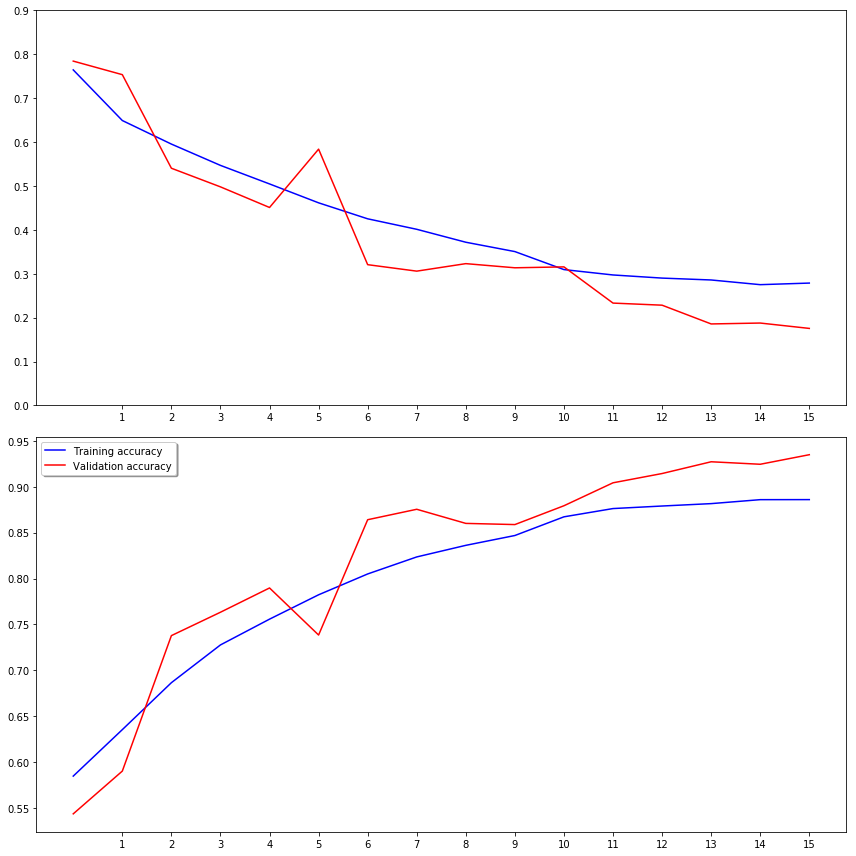

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

huge thanks to Uysim Keras CNN Dog or Cat Classification notebook 